In [1]:
import csv

import pandas as pd

import numpy as np

import torch

from torch import nn, optim

from torch.autograd import Variable

from torch.utils.data import Dataset

from torch.utils.data import DataLoader

In [2]:
# 定义自己的类
class MyDataset(Dataset):
    
    # 初始化
    def __init__(self, file_name):
        # 读入数据
        self.data = pd.read_csv(file_name)
    
    # 返回df的长度
    def __len__(self):
        return len(self.data)
    
    # 获取第idx+1列的数据
    def __getitem__(self, idx):
        return self.data.values[idx,1:10]

# 通过实例化对象来访问该类
# 假设同目录下存在名为median_benchmark.csv的文件
ds = MyDataset('formatweather.csv')
ds=np.asarray(ds[:], dtype = np.float32)#####源文件float32 ,不知道为什么读取变为float64，这里再进行处理  最大最小化时变化
##dl = DataLoader(ds, batch_size=100, shuffle=False)

#####处理为torch，分为trainx，trainy
torchds=torch.from_numpy(ds[:])


In [3]:
train_dataset =torchds[:30700]  ##0.7*43823
test_dataset =torchds[30700:]
dl = DataLoader(train_dataset, batch_size=100, shuffle=True)

In [4]:
class Cnn(nn.Module):

    def __init__(self, in_dim, n_class):

        super(Cnn, self).__init__()

        self.conv = nn.Sequential(

            nn.Conv2d(in_dim, 6, (1,2), stride=(1), padding=(0,1)),#6,1,9

            nn.ReLU(True),

            nn.MaxPool2d(1, 1),#6,1,9

            nn.Conv2d(6, 16, (1,3), stride=(1), padding=(0,1)),

            nn.ReLU(True), nn.MaxPool2d(1, 1))#16,1,9
   
            #5*144

        self.fc = nn.Sequential(

            nn.Linear(144, 16), nn.Linear(16, 8), nn.Linear(8, n_class))



    def forward(self, x):

        out = self.conv(x)

        out = out.view(out.size(0), -1)

        out = self.fc(out)
        
        #out = out.view(5)

        return out

In [11]:
model = Cnn(1, 1)
##model.load_state_dict(torch.load('./weathercnn.pth'))
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [12]:
losslist=[]
for epoch in range(100):
 
    print('epoch {}'.format(epoch + 1))

    print('*' * 10)

    running_loss = 0.0

    for i, data in enumerate(dl, 1):
        
            train_x=data[:,0:8]
            
            train_x=train_x.view(-1,1,1,8)
            
            train_y=data[:,8]
            
            train_y=train_y.view(-1,1)
            
            train_x=Variable(train_x)
            
            train_y=Variable(train_y)
        
            out = model(train_x)

            loss = criterion(out, train_y)
            
            running_loss += loss.item() * train_y.size(0)

            # 向后传播

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
            
    losslist.append(running_loss / (len(train_dataset)))   
           
                
    print('running_loss:-------')
    print(running_loss / (len(train_dataset)))            
    #print(out,train_y)

epoch 1
**********
running_loss:-------
0.009395842852999216
epoch 2
**********
running_loss:-------
0.007889916137443304
epoch 3
**********
running_loss:-------
0.007859749354707252
epoch 4
**********
running_loss:-------
0.007827885823585214
epoch 5
**********
running_loss:-------
0.007796276629225924
epoch 6
**********
running_loss:-------
0.007763392681025381
epoch 7
**********
running_loss:-------
0.0077292697620957316
epoch 8
**********
running_loss:-------
0.007695238439651382
epoch 9
**********
running_loss:-------
0.007658690993040072
epoch 10
**********
running_loss:-------
0.00762148601448934
epoch 11
**********
running_loss:-------
0.007579262148443282
epoch 12
**********
running_loss:-------
0.007543383327734441
epoch 13
**********
running_loss:-------
0.007500998903345013
epoch 14
**********
running_loss:-------
0.007457077783814567
epoch 15
**********
running_loss:-------
0.007412782823970293
epoch 16
**********
running_loss:-------
0.00736629739949777
epoch 17
*********

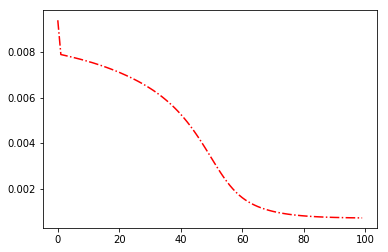

In [13]:
import matplotlib.pyplot as plt
plt.plot(losslist,'r-.') 
plt.show()

In [14]:
train_y.numpy().shape

(100, 1)

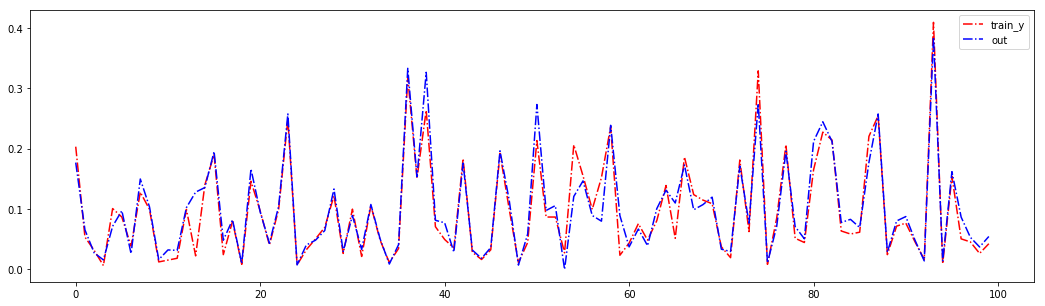

In [15]:
x=range(0,100)
plt.figure(num=1,figsize=(18,5))#定义编号为1 大小为(8,5)
plt.plot(x,train_y.numpy(),'r-.',label='train_y') 
plt.plot(x,out.detach().numpy(),'b-.',label='out') 
plt.legend(loc='best')#显示在最好的位置
plt.show()

In [19]:
model.eval()
    
test_x=test_dataset[:,0:8]

test_x=test_x.view(-1,1,1,8)

test_y=test_dataset[:,8]

test_y=test_y.view(-1,1)

test_x=Variable(test_x)

test_y=Variable(test_y)

out = model(test_x)

loss = criterion(out, test_y)


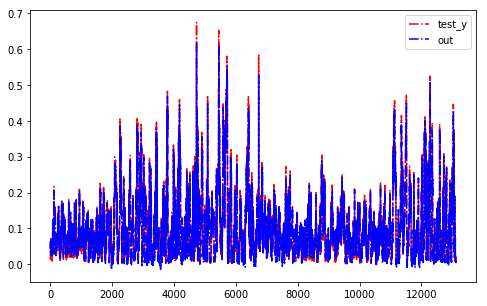

In [17]:
x=range(0,13123)
plt.figure(num=1,figsize=(8,5))#定义编号为1 大小为(8,5)
plt.plot(x,test_y.numpy(),'r-.',label='test_y') 
plt.plot(x,out.detach().numpy(),'b-.',label='out') 
plt.legend(loc='best')#显示在最好的位置
plt.show()

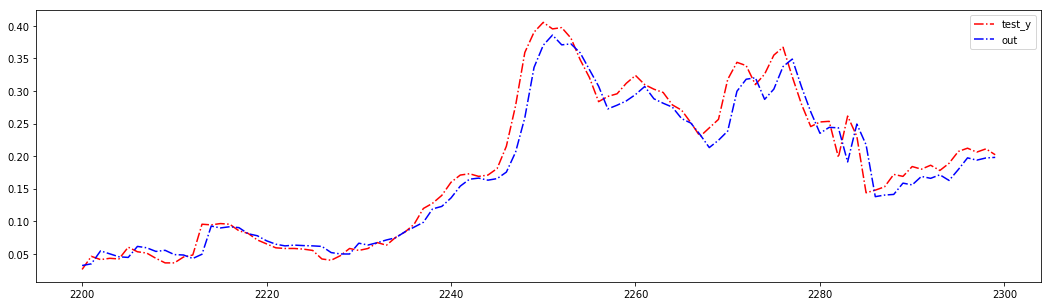

In [22]:
#x=range(0,13123)
x=range(2200,2300)
plt.figure(num=1,figsize=(18,5))#定义编号为1 大小为(8,5)
plt.plot(x,test_y.numpy()[2200:2300],'r-.',label='test_y') 
plt.plot(x,out.detach().numpy()[2200:2300],'b-.',label='out') 
plt.legend(loc='best')#显示在最好的位置
plt.show()

In [23]:
# 保存模型
torch.save(model.state_dict(), './weathercnn-0.01-true-7.6.pth')

In [12]:
out[120:150]

tensor([[0.1062],
        [0.1069],
        [0.1067],
        [0.1068],
        [0.1067],
        [0.1066],
        [0.1066],
        [0.1067],
        [0.1064],
        [0.1060],
        [0.1058],
        [0.1055],
        [0.1053],
        [0.1042],
        [0.1040],
        [0.1016],
        [0.1038],
        [0.1040],
        [0.1043],
        [0.1030],
        [0.1049],
        [0.1057],
        [0.1059],
        [0.1061],
        [0.1060],
        [0.1038],
        [0.1038],
        [0.1052],
        [0.1056],
        [0.1054]], grad_fn=<SliceBackward>)

In [13]:
train_y[10:15]

tensor([[0.0992],
        [0.0992],
        [0.0992],
        [0.0992],
        [0.0992]])

In [ ]:
x=np.array([[0.129779 ,0.352941 ,0.245902 ,0.527273 ,0.666667 ,0.002290 ,0.000000 ,0.0],  
        [0.148893 ,0.367647 ,0.245902 ,0.527273 ,0.666667 ,0.003811 ,0.000000 ,0.0],
        [0.159960 ,0.426471 ,0.229508 ,0.545454 ,0.666667 ,0.005332 ,0.000000 ,0.0],
        [0.182093 ,0.485294 ,0.229508 ,0.563637 ,0.666667 ,0.008391 ,0.037037 ,0.0],
        [0.138833 ,0.485294 ,0.229508 ,0.563637 ,0.666667 ,0.009912 ,0.074074 ,0.0]],dtype = np.float32)
y=np.array([0.1 ,0.1 ,0.1 ,0.1 ,0.1])